<a href="https://colab.research.google.com/github/Venny12/Chinnu/blob/main/Job_Market_Skill_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This command installs essential Python packages and downloads NLTK data needed for text processing
!pip install pandas numpy scikit-learn matplotlib seaborn nltk wordcloud
!python -m nltk.downloader stopwords punkt

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# pandas/numpy: Data manipulation and numerical operations
# matplotlib/seaborn: Data visualization
# TfidfVectorizer: Converts job descriptions into numerical features
# KMeans/DBSCAN: Clustering algorithms to group similar jobs
# PCA: Visualizes high-dimensional data
# silhouette_score: Evaluates clustering quality
# nltk: Natural language processing tools
# WordCloud: Creates visual representations of frequent skills


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import re

# Load CSV file
file_path = "/content/job_listings_linkedIn.csv"
df = pd.read_csv(file_path) #Creates a pandas DataFrame (df) for analysis

# Convert post_date to datetime and create month period
if 'post_date' in df.columns:
    df['post_date'] = pd.to_datetime(df['post_date'])
    df['month'] = df['post_date'].dt.to_period('M')  # Creates "YYYY-MM"
    print("\nTemporal data prepared. Date range:", df['month'].min(), "to", df['month'].max())
else:
    print("\nWarning: 'post_date' column not found - temporal analysis disabled")

# Verify data loaded correctly
print("Data loaded successfully. First 5 rows:")
print(df.head()) # shows the first 5 rows to verify proper loading
print(f"\nTotal records: {len(df)}") # len(df) confirms total number of job postings

# Check required columns exist
# job_title will help label clusters
# description contains the skills we'll analyze
required_columns = {'job_title', 'description', 'post_date'}
if not required_columns.issubset(df.columns):
    missing = required_columns - set(df.columns)
    raise ValueError(f"Missing required columns: {missing}")


Temporal data prepared. Date range: 2024-01 to 2024-12
Data loaded successfully. First 5 rows:
     job_id           job_title  \
0    921716  Software Developer   
1   1829192     Cloud Architect   
2  10998357      Data Scientist   
3  23221523     Product Manager   
4  35982263    Business Analyst   

                                         description  post_date  \
0  Develop applications, Java, C++, web developme... 2024-09-17   
1  Design cloud solutions, AWS, Azure, Kubernetes... 2024-05-28   
2  Analyze data, build machine learning models, P... 2024-12-26   
3  Define product strategy, Agile, market researc... 2024-11-16   
4  Analyze business needs, SQL, Excel, reporting,... 2024-04-02   

                                     job_posting_url           location  \
0  https://www.linkedin.com/jobs/view/921716/?trk...      Princeton, NJ   
1  https://www.linkedin.com/jobs/view/1829192/?tr...   Fort Collins, CO   
2  https://www.linkedin.com/jobs/view/10998357/?t...     Cincinna

In [ ]:
# text preprocessing
# punkt: Tokenizer for splitting text into words
# stopwords: Common words to exclude (e.g., "the", "and")
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# First, ensure all required NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    print("Download complete!")

# Enhanced text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers (but keep words with numbers like Python3)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenize
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()  # Fallback if tokenization fails

    # Remove stopwords and short tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Join back to string
    return ' '.join(tokens)

# Apply cleaning to job descriptions with error handling
df['cleaned_description'] = df['description'].apply(lambda x: clean_text(str(x)))

# Show cleaned data
print("\nOriginal vs Cleaned Descriptions:")
print(df[['description', 'cleaned_description']].head())


Original vs Cleaned Descriptions:
                                         description  \
0  Develop applications, Java, C++, web developme...   
1  Design cloud solutions, AWS, Azure, Kubernetes...   
2  Analyze data, build machine learning models, P...   
3  Define product strategy, Agile, market researc...   
4  Analyze business needs, SQL, Excel, reporting,...   

                                 cleaned_description  
0    develop applications java web development agile  
1  design cloud solutions aws azure kubernetes in...  
2  analyze data build machine learning models pyt...  
3  define product strategy agile market research ...  
4  analyze business needs sql excel reporting sta...  


In [ ]:
# Create TF-IDF vectorizer
# max_features=1000: Keeps only the top 1000 most important terms
# ngram_range=(1, 2): Considers both single words and two-word phrases
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_description'])

# Get feature names (skills/terms)
feature_names = vectorizer.get_feature_names_out()

print(f"Vectorized data shape: {X.shape}")
# Displays the first 20 identified skills/phrases
print(f"First 20 features: {feature_names[:20]}")

Vectorized data shape: (3000, 123)
First 20 features: ['agile' 'agile market' 'analysis' 'analysis siem' 'analyze'
 'analyze business' 'analyze data' 'applications' 'applications java'
 'automate' 'automate deployments' 'aws' 'aws azure' 'azure'
 'azure kubernetes' 'build' 'build data' 'build machine' 'business'
 'business needs']


We have 3000 samples and 123 features
Testing k values: [2, 3, 4, 5, 6, 7, 8, 9]

Testing k=2...
Silhouette score for k=2: 0.2103

Testing k=3...
Silhouette score for k=3: 0.3145

Testing k=4...
Silhouette score for k=4: 0.4174

Testing k=5...
Silhouette score for k=5: 0.5162

Testing k=6...
Silhouette score for k=6: 0.6109

Testing k=7...
Silhouette score for k=7: 0.6999

Testing k=8...
Silhouette score for k=8: 0.8121

Testing k=9...
Silhouette score for k=9: 0.9104


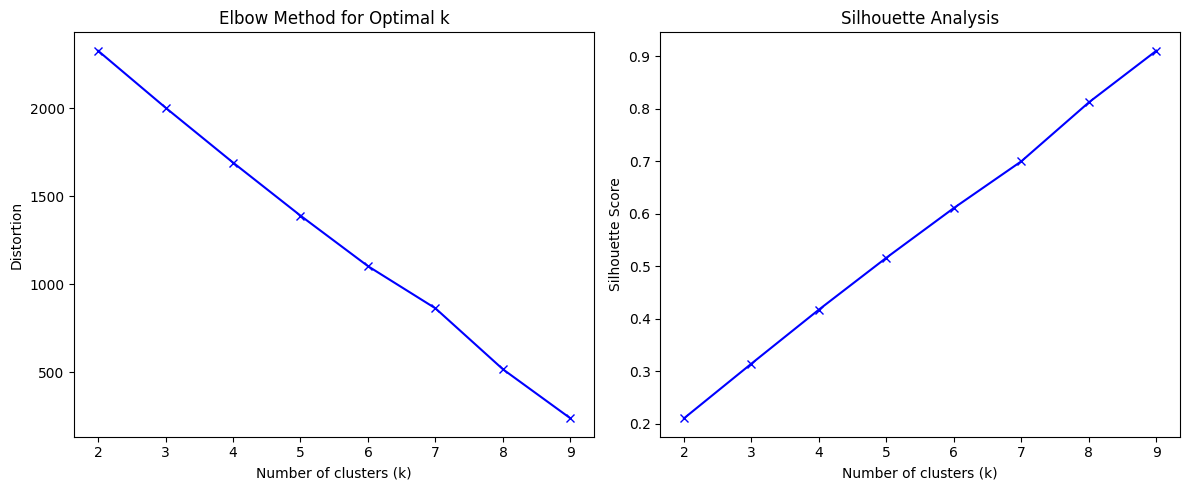


Optimal k based on silhouette scores: 9


In [ ]:
# Elbow Method (Left Plot): Identifies the "natural" number of clusters in your
# job market data by tracking how cluster compactness changes as you increase k.
# X-axis: Number of clusters (k)
# Y-axis: Distortion (sum of squared distances to cluster centers)
# The "elbow point" (where the line bends sharply) suggests the optimal k


# Silhouette Analysis (Right Plot): Evaluates cluster quality by measuring how well-separated clusters are from each other.
# X-axis: Number of clusters (k)
# Y-axis: Silhouette score (-1 to 1, higher is better)
# Peak score indicates the most well-defined clustering

# First, let's check our data shape
print(f"We have {X.shape[0]} samples and {X.shape[1]} features")

# Adjust the range of K based on our sample size
max_possible_k = min(X.shape[0]-1, 9)  # Can't have more clusters than samples-1
K = range(2, max_possible_k+1)  # Start from 2 to max_possible_k

print(f"Testing k values: {list(K)}")

# Elbow method to find optimal k
distortions = []
silhouette_scores = []

for k in K:
    print(f"\nTesting k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

    # Calculate silhouette score (only if k > 1)
    if k > 1:
        cluster_labels = kmeans.predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette score for k={k}: {silhouette_avg:.4f}")

# Plot the elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')

# Plot silhouette scores if we have them
if len(silhouette_scores) > 0:
    plt.subplot(1, 2, 2)
    plt.plot(list(K)[:len(silhouette_scores)], silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Auto-select optimal k based on silhouette score
if len(silhouette_scores) > 0:
    optimal_k = list(K)[np.argmax(silhouette_scores)]
    print(f"\nOptimal k based on silhouette scores: {optimal_k}")
else:
    optimal_k = 2  # Fallback if we can't calculate silhouette
    print("\nUsing default k=2 (not enough samples for silhouette analysis)")

In [ ]:
# Based on the plots, choose optimal k
optimal_k = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Add clusters to dataframe
df['cluster'] = clusters

# Show distribution of clusters
print(df['cluster'].value_counts())

cluster
0    1205
2     930
1     865
Name: count, dtype: int64


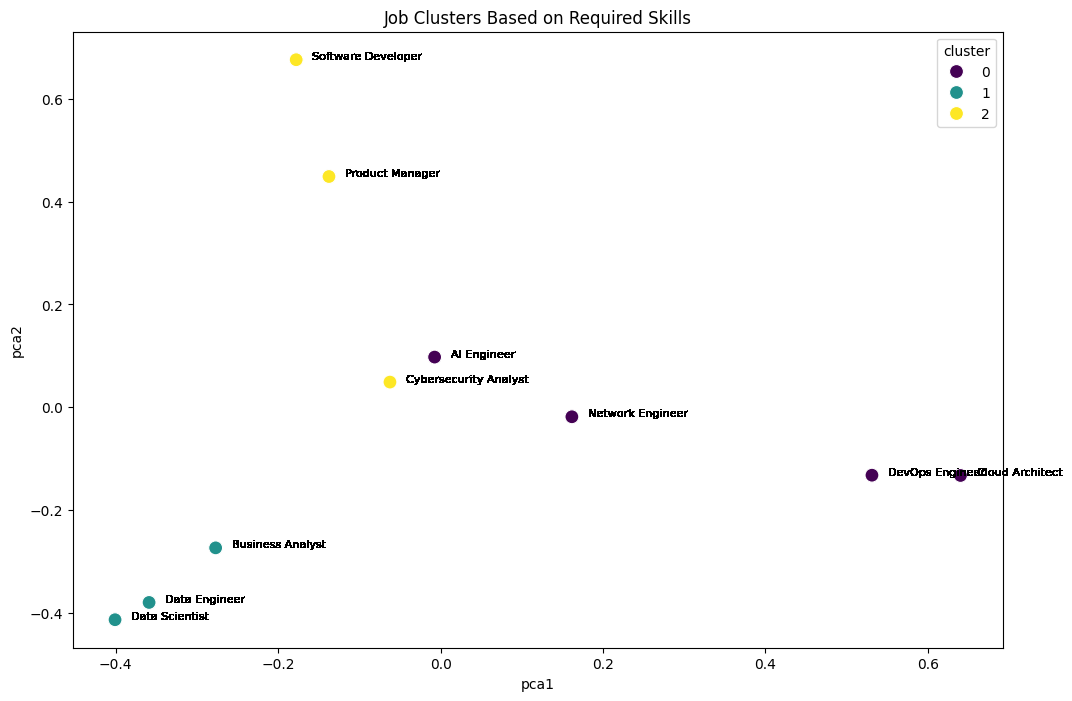

In [ ]:
# 2D visualization of your job clusters using PCA (Principal Component Analysis)
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())

# Create a DataFrame for visualization
vis_df = pd.DataFrame(reduced_features, columns=['pca1', 'pca2'])
vis_df['cluster'] = clusters
vis_df['job_title'] = df['job_title']

# Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=vis_df, x='pca1', y='pca2', hue='cluster',
                palette='viridis', s=100)
for i in range(len(vis_df)):
    plt.text(vis_df['pca1'][i]+0.02, vis_df['pca2'][i],
             vis_df['job_title'][i], fontsize=8)
plt.title('Job Clusters Based on Required Skills')
plt.show()


Cluster 0 - Key Skills:
            features     score
0         kubernetes  0.124866
1                aws  0.124866
2              cloud  0.117117
3          solutions  0.114352
4             docker  0.080443
5        deployments  0.080443
6   deployments cicd  0.080443
7     kubernetes aws  0.080443
8  docker kubernetes  0.080443
9        cicd docker  0.080443


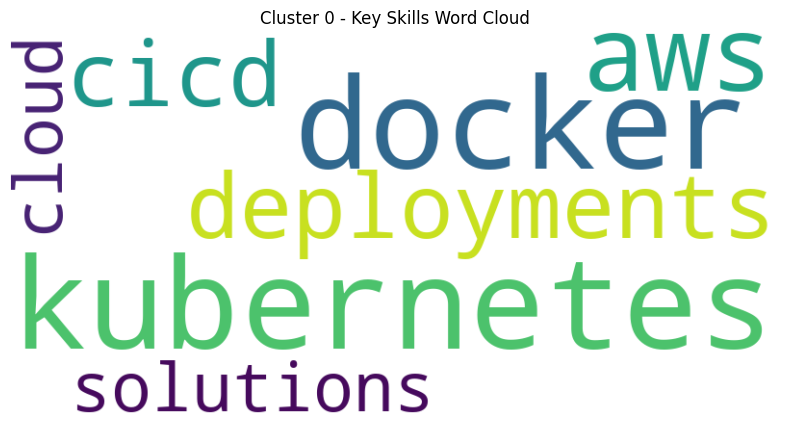


Cluster 1 - Key Skills:
                 features     score
0                    data  0.203708
1                     sql  0.176181
2                 analyze  0.139950
3                   build  0.135818
4             stakeholder  0.091155
5   reporting stakeholder  0.091155
6              management  0.091155
7               needs sql  0.091155
8                   needs  0.091155
9  stakeholder management  0.091155


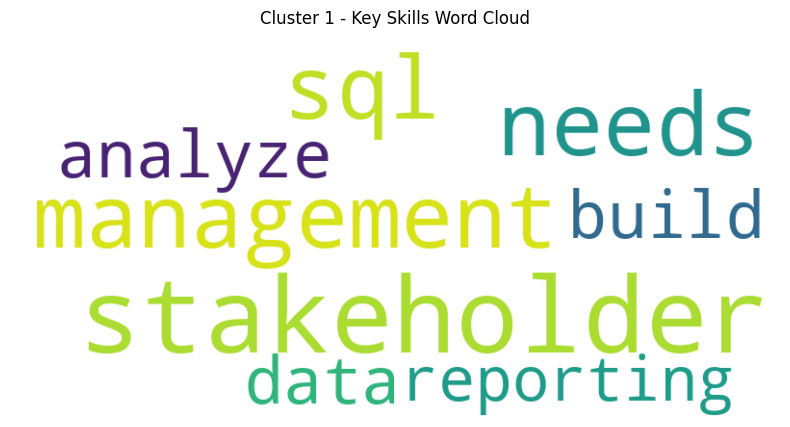


Cluster 2 - Key Skills:
               features     score
0                 agile  0.152623
1                   web  0.107302
2       web development  0.107302
3     development agile  0.107302
4     applications java  0.107302
5          applications  0.107302
6  develop applications  0.107302
7              java web  0.107302
8           development  0.107302
9                  java  0.107302


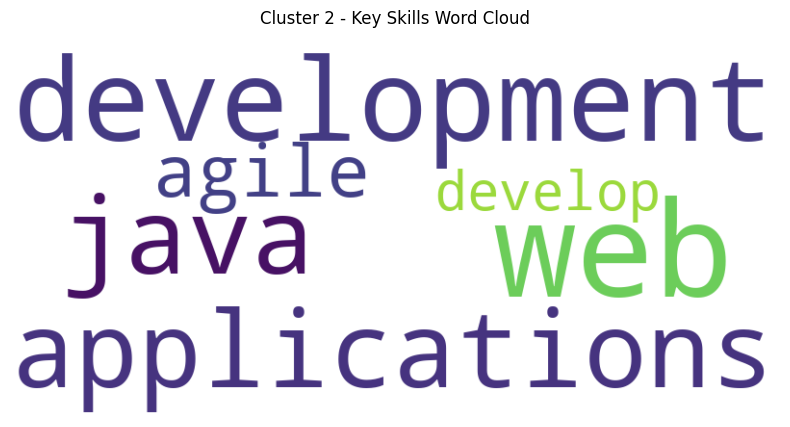

In [ ]:
# Function to extract the most important skills/features for each cluster
def get_top_features_cluster(tfidf_array, prediction, n_features):
    """
    Identifies the top n features (skills) that characterize each cluster

    Args:
        tfidf_array: The TF-IDF transformed job descriptions (numerical features)
        prediction: Cluster assignments for each job
        n_features: Number of top skills to return per cluster

    Returns:
        DataFrame containing top skills and their importance scores for each cluster
    """
    labels = np.unique(prediction)  # Get unique cluster labels
    dfs = []  # Store DataFrames for each cluster

    for label in labels:
        # Get indices of jobs belonging to this cluster
        id_temp = np.where(prediction==label)

        # Calculate mean TF-IDF scores across all jobs in the cluster
        x_means = np.mean(tfidf_array[id_temp], axis=0)

        # Get indices of top n features with highest mean scores
        sorted_means = np.argsort(x_means)[::-1][:n_features]

        # Get the actual feature names (skill terms)
        features = vectorizer.get_feature_names_out()

        # Pair feature names with their scores
        best_features = [(features[i], x_means[i]) for i in sorted_means]

        # Create DataFrame for this cluster's top skills
        df_temp = pd.DataFrame(best_features, columns=['features', 'score'])
        df_temp['cluster'] = label
        dfs.append(df_temp)

    # Combine all cluster DataFrames
    return pd.concat(dfs)

# Get top 10 skills for each cluster
top_features = get_top_features_cluster(X.toarray(), clusters, 10)

# Display and visualize results for each cluster
for cluster in sorted(top_features['cluster'].unique()):
    # Print top skills table
    print(f"\nCluster {cluster} - Key Skills:")
    cluster_features = top_features[top_features['cluster'] == cluster]
    print(cluster_features[['features', 'score']].head(10))

    # Create word cloud visualization
    text = ' '.join(cluster_features['features'])
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster} - Key Skills Word Cloud')
    plt.axis('off')
    plt.show()

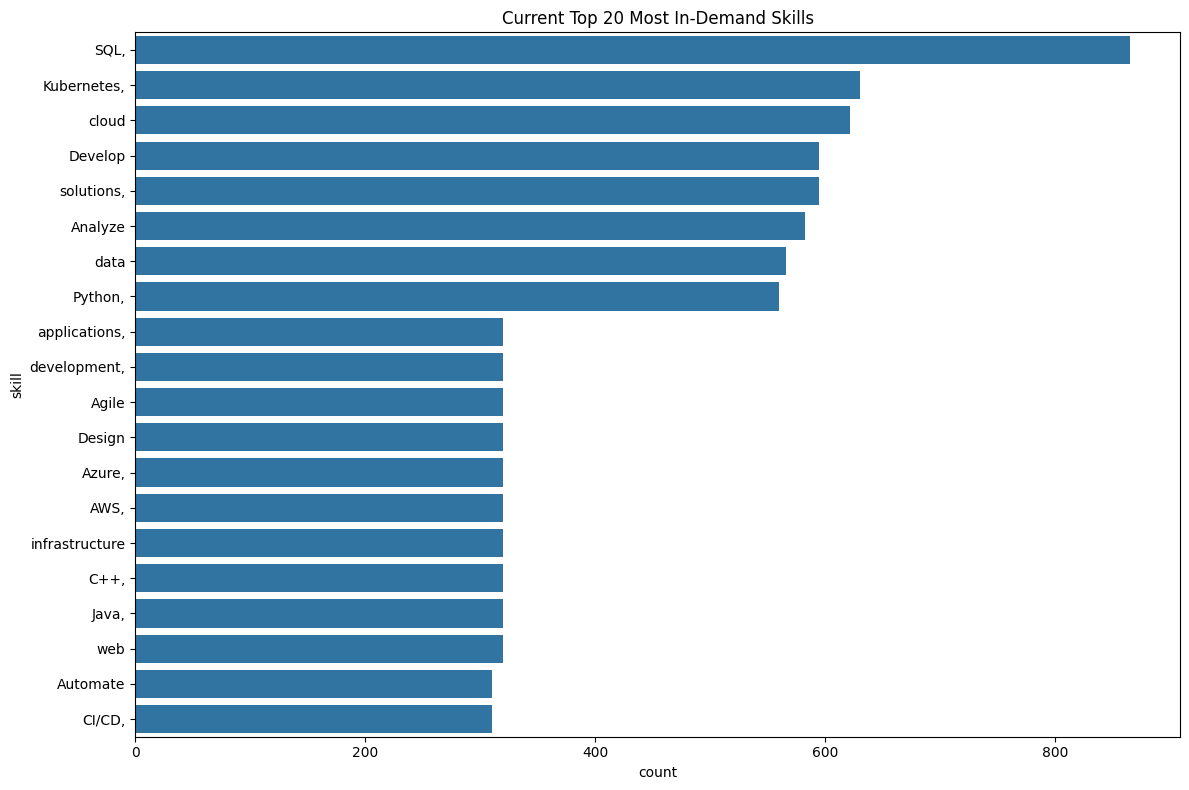

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker as mtick

# 1. Data Preparation
df['post_date'] = pd.to_datetime(df['post_date'])
df['month'] = df['post_date'].dt.to_period('M')

# 2. Current Skill Analysis
all_skills = ' '.join(df['description'].astype(str)).split()
skill_counts = pd.Series(all_skills).value_counts().reset_index()
skill_counts.columns = ['skill', 'count']

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='skill',
            data=skill_counts.head(20),
            color='#1f77b4')  # Standard blue color
plt.title('Current Top 20 Most In-Demand Skills')
plt.tight_layout()
plt.show()

# 3. Emerging Skills Analysis (Temporal)
if len(df['month'].unique()) > 1:
    try:
        # Create monthly skill frequency table
        monthly_skills = (
            df.groupby('month')['description']
            .apply(lambda x: pd.Series(' '.join(x).split()))
            .value_counts()
            .unstack(level=0)
            .fillna(0)
        )

        # Calculate growth rates safely
        first_period = monthly_skills.iloc[:, 0]
        last_period = monthly_skills.iloc[:, -1]

        with np.errstate(divide='ignore', invalid='ignore'):
            growth_rates = (last_period - first_period) / first_period.replace(0, np.nan)
            growth_rates = growth_rates.replace([np.inf, -np.inf], np.nan).dropna()

        emerging_skills = (
            pd.Series(growth_rates, name='growth_rate')
            .sort_values(ascending=False)
            .head(10))

        print("\nTop 10 Emerging Skills (Growth Rate %):")
        print(emerging_skills.apply(lambda x: f"{x:.0%}").to_string())

        plt.figure(figsize=(12, 6))
        emerging_skills.plot(kind='bar', color='#1f77b4')  # Standard blue color
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.title('Top Emerging Skills by Growth Rate')
        plt.ylabel('Growth Rate')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("\n")
else:
    print(f"\nInsufficient time periods for trend analysis (found {len(df['month'].unique())} period(s))")

In [ ]:
# Save the clustered data
df.to_csv('clustered_job_data.csv', index=False)

# Save the clustering model for future use
import joblib
joblib.dump(kmeans, 'skill_cluster_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Download the files to your local machine
from google.colab import files
files.download('clustered_job_data.csv')
files.download('skill_cluster_model.pkl')
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>